In [1]:
from besos import eppy_funcs as ef, optimizer
from besos import eplus_funcs as ep
from besos.problem import EPProblem
from besos.parameters import expand_plist
from besos.objectives import *
from besos.evaluator import EvaluatorEP
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist, wwrSelector
from besos.optimizer import NSGAII, SPEA2
from platypus.evaluator import MapEvaluator
from besos.objectives import MeterReader,time_series_values,EPResults
import platypus
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dask.distributed import Client
import math

C:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
building = ef.get_building('Modelo_teste_Brise_vertical_0graus.idf')

In [14]:
# 2) Criar o parâmetro do ângulo do brise (variável de decisão)

param_angle = Parameter(
    name="Brise Angle",
    value_descriptors=RangeParameter(min_val=0, max_val=90)
)

parameters = [param_angle]

# 3) Criar os objetivos
EPobjectives = ['ElectricityProduced:Facility','Electricity:Facility']  
besos_problem = EPProblem(parameters, EPobjectives, minimize_outputs=[False,True])  # Criando uma instância do problema;

# 4) Criar um Selector personalizado para converter ângulo em coordenadas
from besos.parameters import Selector

class BriseSelector(Selector):
    def get(self, building):
        return 0.0  # Valor inicial do ângulo, não usado diretamente

    def set(self, building, angle):
        """Recebe o ângulo e aplica as coordenadas calculadas no IDF."""
        base_length = 1.03  # Comprimento do brise
        x = 6.62-(base_length * math.sin(math.radians(angle)))
        y = -base_length * math.cos(math.radians(angle))

        # Acessar o objeto "Brise horizontal" no IDF
        shading_obj = building.getobject("Shading:Building:Detailed", "Brise Vertical")
        
        # Atualizar as coordenadas dos vértices 2 e 3
        shading_obj["Vertex_1_Xcoordinate"] = x
        shading_obj["Vertex_2_Xcoordinate"] = x
        shading_obj["Vertex_1_Ycoordinate"] = y
        shading_obj["Vertex_2_Ycoordinate"] = y

# 5) Criar o parâmetro com o Selector personalizado
param_brise = Parameter(
    selector=BriseSelector(),
    name="Brise Angle",
    value_descriptors=RangeParameter(min_val=0, max_val=90)
)

parameters = [param_brise]

besos_problem = EPProblem(parameters, EPobjectives, minimize_outputs=[False,True])  # Criando uma instância do problema;



In [15]:
from platypus import NSGAII, Real, Problem
from datetime import datetime
from besos.evaluator import EvaluatorEP, Problem


evaluator = EvaluatorEP(problem=besos_problem, building=building, epw="RS_Pelotas.epw", err_dir='errdir')

# Função para congelar (hash) valores, convertendo FixedLengthArray em tupla
def custom_freeze(value):
    if isinstance(value, FixedLengthArray):
        return tuple(value)  # Converte FixedLengthArray em tupla
    elif isinstance(value, list):
        return tuple(custom_freeze(v) for v in value)
    else:
        return value

# Substituir _freeze do besos pelo custom_freeze
import besos.evaluator
#besos.evaluator._freeze = custom_freeze
# Redefinir o cache em cada chamada para contornar o problema

original_call = besos.evaluator.AbstractEvaluator.__call__
def call_no_cache(self, values, **kwargs):
    self._cache = {}  # Reiniciar o cache para evitar erro de hash
    return original_call(self, values, **kwargs)

besos.evaluator.AbstractEvaluator.__call__ = call_no_cache
 #Criar uma função wrapper para evitar o uso de cache
class NoCacheEvaluator(EvaluatorEP):
    def __call__(self, values, **kwargs):
        # Apenas executa a avaliação sem cache
        return self.eval_single(values)  # Aqui, chamamos diretamente o método sem modificar o cache

# Substituir o avaliador original pelo sem cache
evaluator = NoCacheEvaluator(problem=besos_problem, building=building, epw="RS_Pelotas.epw", err_dir='errdir')


# Iniciar o NSGAII
startTime = datetime.now()
algorithm = NSGAII(evaluator.to_platypus(), population_size=100, expand_objects=True)
algorithm.run(30)  
print(datetime.now() - startTime)
results = algorithm.result
# Capturar e imprimir os resultados
for solution in results:
    
    print("Variáveis de decisão:", solution.variables)
    print("Objetivos:", solution.objectives)
    

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running Ener

In [16]:
results = optimizer.solutions_to_df(algorithm.result, problem=besos_problem, parts=["inputs", "outputs"])
results

,Brise Angle,ElectricityProduced:Facility,Electricity:Facility,pareto-optimal
0,1.266664,1.220414e+09,1.544196e+10,True
1,2.069977,1.216121e+09,1.544182e+10,True
2,3.198112,1.209968e+09,1.544164e+10,True
3,3.274626,1.209545e+09,1.544163e+10,True
4,3.331504,1.209232e+09,1.544162e+10,True
...,...,...,...,...
95,84.491644,7.264271e+08,1.545334e+10,False
96,86.171944,7.218654e+08,1.545434e+10,False
97,87.814533,7.180240e+08,1.545522e+10,False
98,88.167880,7.172432e+08,1.545542e+10,False


In [17]:
#results['Desconf. 80%'] = (results['Desconf. 80%']*(-1))/100
#results['Power_inv'] = (results['Power_inv']/1000)
results['ElectricityProduced:Facility'] = (results['ElectricityProduced:Facility']/3600000)
results['Electricity:Facility'] = (results['Electricity:Facility']/3600000)

results

,Brise Angle,ElectricityProduced:Facility,Electricity:Facility,pareto-optimal
0,1.266664,339.003892,4289.432040,True
1,2.069977,337.811340,4289.395326,True
2,3.198112,336.102321,4289.345705,True
3,3.274626,335.984610,4289.342437,True
4,3.331504,335.897820,4289.339985,True
...,...,...,...,...
95,84.491644,201.785308,4292.593978,False
96,86.171944,200.518173,4292.871457,False
97,87.814533,199.451112,4293.115753,False
98,88.167880,199.234208,4293.173198,False


Text(0, 0.5, 'Consumo de energia elétrica (kWh.ano)')

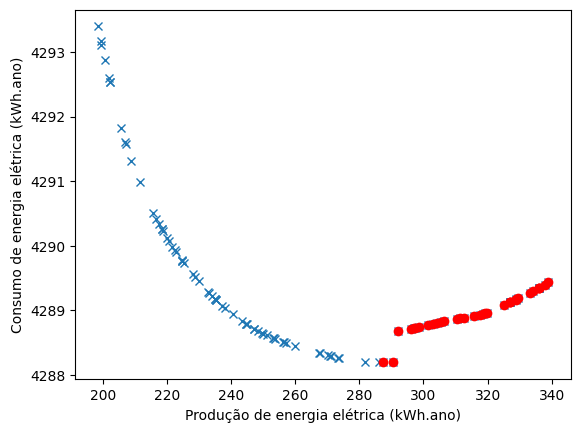

In [18]:
optres = results.loc[results['pareto-optimal']==True,:] # pareto-ótimo
plt.plot(results['ElectricityProduced:Facility'], results['Electricity:Facility'],'x') 
plt.plot(optres['ElectricityProduced:Facility'], optres['Electricity:Facility'],'ro')
plt.xlabel('Produção de energia elétrica (kWh.ano)')
plt.ylabel('Consumo de energia elétrica (kWh.ano)')

#plt.axis([1010,750,34590,34604]) #Seta a dimensão do grafico

In [19]:
optres

,Brise Angle,ElectricityProduced:Facility,Electricity:Facility,pareto-optimal
0,1.266664,339.003892,4289.432040,True
1,2.069977,337.811340,4289.395326,True
2,3.198112,336.102321,4289.345705,True
3,3.274626,335.984610,4289.342437,True
4,3.331504,335.897820,4289.339985,True
5,4.477173,334.123365,4289.292195,True
6,4.999366,333.302471,4289.271178,True
7,7.309243,329.605270,4289.183315,True
8,7.770855,328.843045,4289.166924,True
9,7.788897,328.813407,4289.166277,True


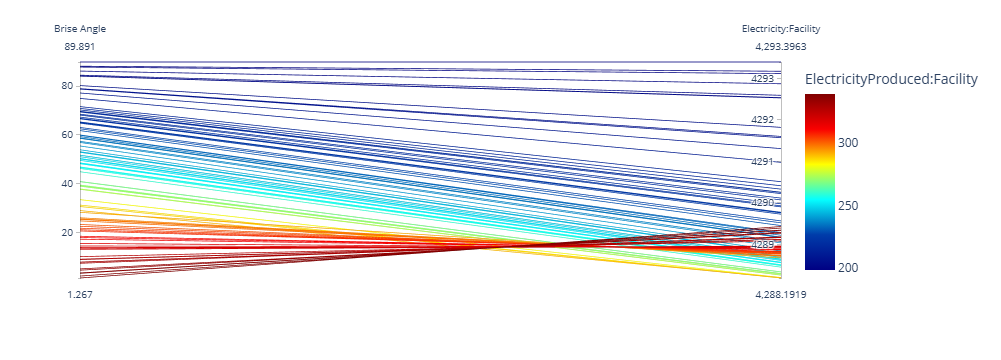

In [20]:
import plotly
import numpy
#results.iteritems = df.items
#results.rename(columns={'RangeParameter [0.1, 0.9]': 'RangeParameter'}, inplace=True)

plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
fig = px.parallel_coordinates(results,color="ElectricityProduced:Facility", dimensions=[
    "Brise Angle","Electricity:Facility"],
    color_continuous_scale=px.colors.sequential.Jet)
fig.show()